# Building Explainable Machine Learning Models
## Exercise: Explaining models with LIME

LIME stands for Local Interpretable Model-Agnostic Explanations) 
It generates an explanation by approximating the underlying model by an interpretable one.


During this exercise,  you are going to be using LIME by working on a credit card dataset. You'll perform the following steps:

* Train a model on a text and image dataset,
* Explain the predicitons of a classifier using LIME technique.




Let's get started!

# LIME


![](https://imgur.com/mthfL6t.png)

source: [Documentation of LIME](https://github.com/marcotcr/lime)



---

# Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [1]:
%pip install torch -qq
%pip install torchvision -qq
%pip install lime -qq


import os
import numpy as np   
import pandas as pd  

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
import gc
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# For image manipulations
from PIL import Image
import skimage
from skimage.io import imread

np.random.seed(123) #ensure reproducibility
RANDOM_STATE = 42

## Model Interpretation package
import lime
from lime import lime_tabular
from lime import lime_text
from lime import lime_image

import warnings  
warnings.filterwarnings("ignore")

In [2]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(10,6)})

# Case Study - Text Dataset



 ### Christianity or Atheism? 



![](https://imgur.com/1ZvznRv.png)


We'll be using the 20 newsgroups dataset. The data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. The dataset can be freely downloaded from [here](http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups). For this study we'll only work with two classes that are hard to distinguish because they share many words: Christianity and atheism

> **Source**:
>Original Owner and Donor:
>
>Tom Mitchell
>School of Computer Science
>Carnegie Mellon University
>tom.mitchell '@' cmu.edu
>http://www.cs.cmu.edu/~tom/



## Reading in the Dataset

In [12]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

## Data Preparation

In [13]:
# Vectorization using tfidf vectorizer

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

## Training a Random Forest Model

Training a random forest with 500 trees, 

In [14]:
model_rf_text = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
model_rf_text.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(n_estimators=500)

In [15]:
pred = model_rf_text.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

0.9177288528389339

## Explaining predicitions with LIME Text

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implements predict_proba on raw_text lists.

In [16]:
from lime import lime_text
c = make_pipeline(vectorizer, model_rf_text)


In [17]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

Let’s look at an explanation for an arbitrary instance in the test set.

In [18]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.452
True class: atheism


## Visualizing explanations

In [19]:
exp.show_in_notebook(text=False)

We can also include a visualization of the original document, with the words in the explanations highlighted. 

In [20]:
exp.show_in_notebook(text=True)

### Interpretation

The blue words indicate atheism, while orange words indicate christianity.The numbers indicate the weights which can be applied to the prediction probabilites to interpret them.

# Case Study - Image Dataset

### Husky(Dog) or Wolf?
We want to explain a classifier that predicts whether the given image is of a husky or a wolf.



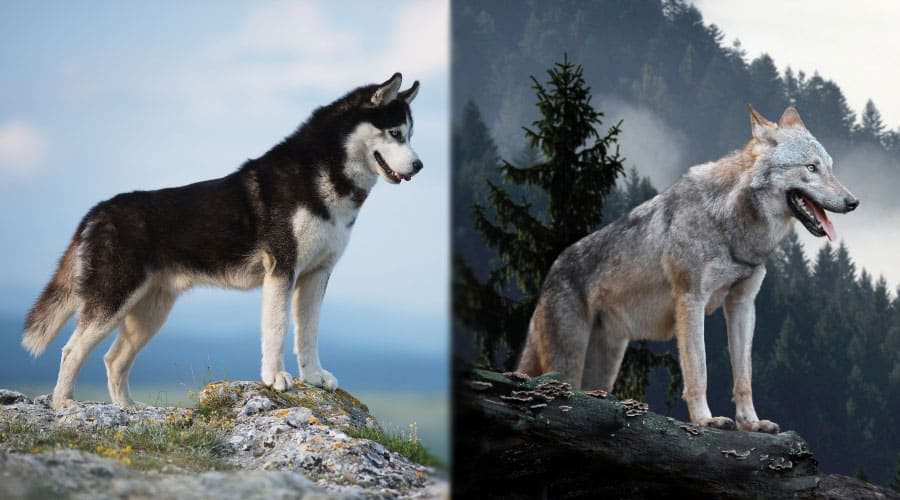

In [21]:
Image.open('../data/husky_or_wolf.jpg')

*Image_source - [Siberian Husky vs. Wolf: Are They Related?](https://www.loveyourdog.com/siberian-husky-vs-wolf/#:~:text=The%20Husky%20and%20the%20wolf%20look%20very%20similar.&text=The%20Husky%20is%20a%20large,between%2026%20and%2032%20inches.)*

## Training dataset


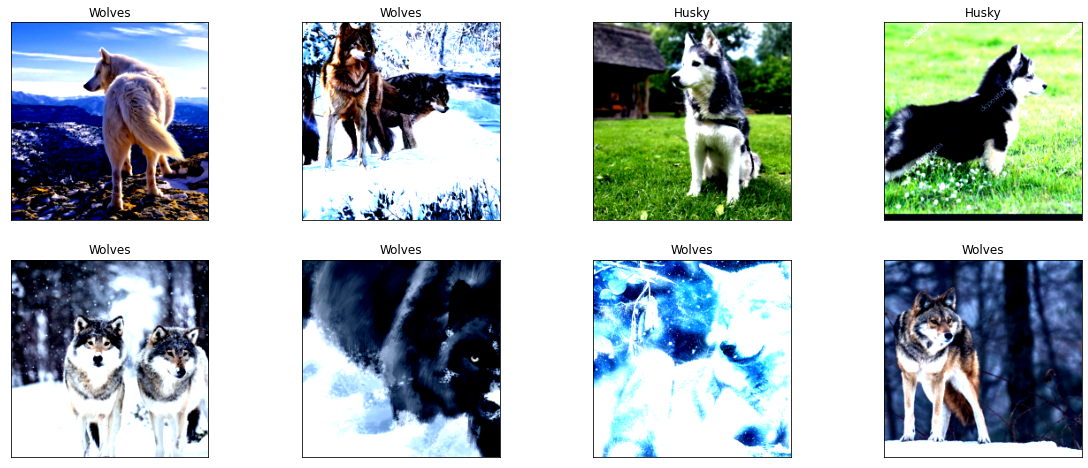

In [22]:
Image.open('../data/training_set.png')

We'll take the image and divide it into interpretable components (contiguous superpixels).

In [23]:
classes = dict({0: 'Husky',
               1: 'Wolf'})

## Reading and preprocessing the test image

We will resize and preprocess the image.

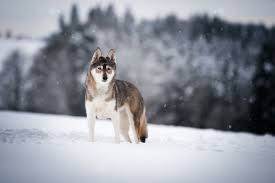

In [24]:
test_img = Image.open('../data/husky.jpg').convert('RGB')
test_img 

We will define two separate transforms:
* (1) to take PIL image, resize and crop it 
* (2) take resized, cropped image and apply whitening.

In [25]:
# resize and take the center part of image to what our model expects
#source: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

## Loading the pretrained Pytorch model

We are going to use the pre-trained model.

In [36]:
#Download the model from https://drive.google.com/drive/folders/1w-FS2GU4_f-scDFLT4h6nmj7enuxoz2z?usp=sharing and place it in model folder.

model = torch.load('../model/trained_model2',map_location=torch.device('cpu'))



## Predicting the class of the input Image



In [27]:
#source: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [28]:
test_pred = batch_predict([pill_transf(test_img)])
test_pred.squeeze().argmax()

1

## Explaining predictions with LIME Image

The model predicts that the the probability for the given images to be a Wolf. Let's now understand why the model thinks it to be a wolf and not husky. We'll use Lime to generate explanations for us.

* Generate random perturbations for input image by turning on and off some of the super-pixels in the image.
* Use a classifier to predict classes of new generated images
* Calculate distances between the original image and each of the perturbed images and compute the weights (importance) of each perturbed image
* Use perturbations, predictions and weights to fit an explainable (linear) model
* Calculate the top superpixels

In [29]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [30]:
explanation = explainer.explain_instance(np.array(pill_transf(test_img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classifier

## Visualizing the Explanations

We can see the top 10 superpixels that are most positive towards the class 

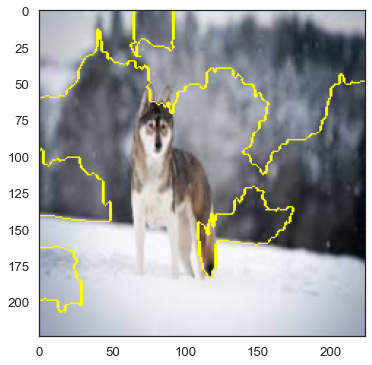

In [31]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

* the rest of the image hidden

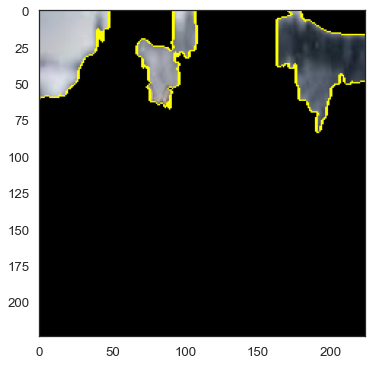

In [32]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)




[1] https://github.com/marcotcr/lime

[2] C. Molnar, [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/lime.html), 

---